[*********************100%%**********************]  1 of 1 completed


Epoch 1/5
52/52 [==============================] - 20s 296ms/step - loss: 0.0983
Epoch 2/5
52/52 [==============================] - 16s 308ms/step - loss: 0.0636
Epoch 3/5
52/52 [==============================] - 17s 320ms/step - loss: 0.0621
Epoch 4/5
52/52 [==============================] - 16s 301ms/step - loss: 0.0610
Epoch 5/5
52/52 [==============================] - 16s 309ms/step - loss: 0.0642


[*********************100%%**********************]  1 of 1 completed


33/33 [==============================] - 4s 107ms/step


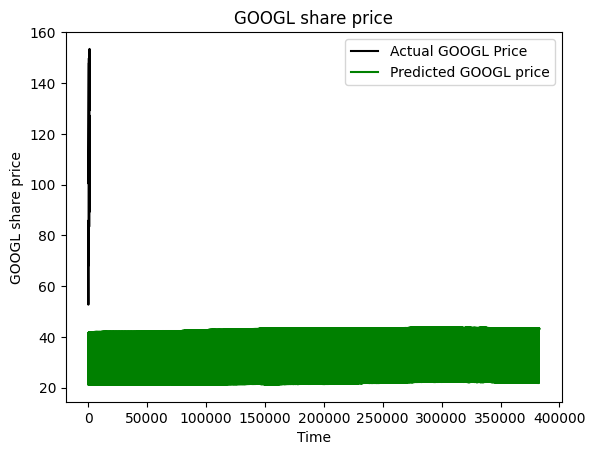

33/33 [==============================] - 3s 76ms/step
Prediction: [[21.224209]
 [25.525526]
 [29.21636 ]
 ...
 [43.260048]
 [43.245857]
 [43.236263]]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

# Load data
company = 'GOOGL'
start = dt.datetime(2012, 1, 1)
end = dt.datetime(2020, 1, 1)

data = yf.download(company, start, end)

# Prepare data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

prediction_days = 365

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x - prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Prediction of the next stock price
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=5, batch_size=32)

# Test the model accuracy on existing data
test_start = dt.datetime(2020, 1, 1)
test_end = dt.datetime.now()

test_data = yf.download(company, test_start, test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']))

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

# Make predictions on test data
x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x - prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = np.array(predicted_prices).reshape(-1, 1)
predicted_prices = scaler.inverse_transform(predicted_prices)

# Plot the test predictions
plt.plot(actual_prices, color='black', label=f"Actual {company} Price")
plt.plot(predicted_prices, color='green', label=f"Predicted {company} price")
plt.title(f"{company} share price")
plt.xlabel('Time')
plt.ylabel(f"{company} share price")
plt.legend()
plt.show()

# Predict next day
real_data = model_inputs[len(model_inputs) - prediction_days:]
real_data = real_data.reshape(1, -1)
real_data = real_data.reshape(-1, 1)
real_data = scaler.transform(real_data)
real_data = real_data.reshape((1, prediction_days, 1))
prediction = model.predict((x_test))
prediction = np.array(prediction).reshape(-1, 1)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction: {prediction}")